# Unpacking TACO Annotations Json

In [1]:
import pandas as pd
import json
import shutil

In [2]:
category_conversion = {}
category_conversion['metal'] = [0,8,10,11,12,28]
category_conversion['cardboard'] = [13,14,15,16,17,18,19,20]
category_conversion['glass'] = [6,9,23,26]
category_conversion['paper'] = [21,30,31,32,33,34]
category_conversion['plastic'] = [4,5,7,24,27,43,44,47,49,55]
category_conversion['trash'] = [1,2,3,22,25,29,35,36,37,38,39,40,41,42,45,46,48,50,51,52,53,54,57,58,59]

In [3]:
def open_json(n):
    """opens the json for taco batch and extracts the image and category data"""
    file = open(f'/Users/Lucy/code/MeylerL/waste_classification/raw_data/TACO/taco_jsons/batch_{n}_annotations.json')
    data = json.load(file)
    image_data = data['images']
    category_data = data['annotations']
    return image_data, category_data

In [4]:
def image_ids(image_data):
    """ returns a dict with image_ids and image file names"""
    image_files = {}
    for item in image_data:
        image_files[item['id']] = item['file_name']
    return image_files

In [27]:
def image_categories(category_data):
    """ returns a dict with the image_ids and the taco category numbers labelling that image"""
    image_categories_dict = {}
    for item in category_data:
        if item['image_id'] in image_categories_dict:
            image_categories_dict[item['image_id']].append(item['category_id'])
        else:
            image_categories_dict[item['image_id']] = [item['category_id']]
    for key in image_categories_dict:
        image_categories_dict[key] = list(set(image_categories_dict[key]))
    return image_categories_dict

In [6]:
def compatible_images(image_categories):
    """ returns a dict with image_id and category, only includes images that are labelled 
    with one trashnet category"""
    new_image_categories = {}
    for key in image_categories.keys():
        target_list = []
        for label in image_categories[key]:
            if label in category_conversion['trash']:
                target_list.append('trash')
            elif label in category_conversion['cardboard']:
                target_list.append('cardboard')
            elif label in category_conversion['plastic']:
                target_list.append('plastic')
            elif label in category_conversion['paper']:
                target_list.append('paper')
            elif label in category_conversion['metal']:
                target_list.append('metal')
            elif label in category_conversion['glass']:
                target_list.append('glass')
        new_image_categories[key] = target_list
    for key in new_image_categories:
        new_image_categories[key] = list(set(new_image_categories[key]))
    final_images = {k:v for k,v in new_image_categories.items() if len(v) <= 1}
    return final_images

In [11]:
def move_images(n, final_images, image_files):
    """creates dataframe of images to be moved and moves them to relevant trashnet folder"""
    id_category_df = pd.DataFrame.from_dict(final_images, orient ='index')
    id_filename_df = pd.DataFrame.from_dict(image_files, orient ='index')
    image_df = id_category_df.merge(id_filename_df, left_index=True, right_index=True)
    image_df.rename(columns = {'0_x':'category', '0_y':'filename'}, inplace = True)
    for index, row in image_df.iterrows():
        shutil.move(f'/Users/Lucy/code/MeylerL/waste_classification/raw_data/TACO/data/batch_{n}/{row["filename"]}',
                f'/Users/Lucy/code/MeylerL/waste_classification/raw_data/taco_sorted/{row["category"]}/batch_{n}{row["filename"]}')
    return None

In [28]:
# looping through all taco jsons to move images to relevant trahsnet folders
for item in range(2,16):
    image_data, category_data = open_json(item)
    image_files = image_ids(image_data)
    image_cats = image_categories(category_data)
    final_images = compatible_images(image_cats)
    move_images(item, final_images, image_files)

# Loading Unpacked Taco

In [15]:
%load_ext autoreload
%autoreload 2
import tensorflow 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomRotation, RandomFlip
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.data import AUTOTUNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Saving model

In [22]:
from waste_classification.trainer import Trainer
import os
import joblib
import tensorflow as tf
import numpy as np

/Users/Lucy/code/MeylerL/waste_classification/pretrained_models
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
52/52 [==============================] - 589s 11s/step - loss: 3.0142 - accuracy: 0.3608 - val_loss: 1.4047 - val_accuracy: 0.4792
accuracy plot saved at Accuracy.jpg


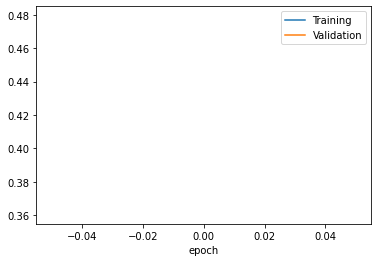

In [10]:
model_dir = "/Users/Lucy/code/MeylerL/waste_classification/pretrained_models"
print(model_dir)
t = Trainer()
t.load_data(gcp=False, use_taco=False)
t.train_model(model_type="ResNet50", epochs=1)



In [11]:
t.evaluate_score()


NameError: name 'model' is not defined

In [14]:
t.model.save(os.path.join(model_dir, "keras_model"))

2021-09-07 14:41:53.580201: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


KeyboardInterrupt: 

In [30]:
t.test_ds_local

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [17]:
tf.keras.models.save_model(t.model, model_dir)

INFO:tensorflow:Assets written to: /Users/Lucy/code/MeylerL/waste_classification/pretrained_models/assets


INFO:tensorflow:Assets written to: /Users/Lucy/code/MeylerL/waste_classification/pretrained_models/assets
/Users/Lucy/.pyenv/versions/3.8.6/envs/waste_classification/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [27]:
model = tf.keras.models.load_model(model_dir)

In [28]:
result = model.predict(t.test_ds_local)
result

KeyboardInterrupt: 

In [25]:
np.argmax(result,axis=1)

array([3, 3, 1, 4, 1, 1, 3, 1, 1, 1, 2, 1, 3, 3, 4, 1, 1, 1, 1, 3, 3, 0,
       3, 3, 3, 1, 0, 0, 1, 1, 4, 1, 3, 1, 2, 1, 1, 3, 0, 3, 3, 1, 1, 3,
       3, 1, 3, 1, 3, 4, 1, 1, 0, 1, 2, 1, 1, 3, 0, 1, 0, 1, 1, 1, 3, 0,
       1, 0, 3, 1, 0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1,
       1, 3, 3, 0, 3, 3, 1, 0, 0, 1, 3, 1, 3, 1, 3, 1, 1, 1, 4, 0, 3, 1,
       0, 3, 1, 1, 1, 3, 3, 0, 1, 1, 3, 1, 1, 0, 1, 4, 1, 3, 1, 0, 3, 1,
       4, 1, 1, 0, 3, 2, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 0, 3, 1, 0,
       0, 0, 1, 1, 0, 1, 3, 4, 3, 1, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 3, 0, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1,
       1, 3, 0, 1, 1, 1, 0, 3, 3, 0, 3, 1, 0, 3, 4, 3, 1, 1, 3, 1, 1, 1,
       3, 1, 3, 3, 1, 0, 1, 3, 3, 1, 4, 1, 1, 1, 1, 2, 3, 3, 2, 1, 1, 3,
       1, 3, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 0, 1, 0, 2, 3, 3, 1, 0, 1, 3,
       3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 4, 1, 1, 1,

In [ ]:
model_saved = joblib.load(os.path.join(model_dir, "model.joblib"))

In [ ]:
model_saved.predict(t.test_ds_local)